In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [105]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [106]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]


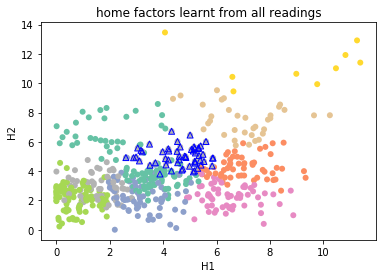

In [131]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 8
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]

ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='blue', marker='^', facecolors='none')



In [135]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]

test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [136]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]


idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [137]:
from sklearn.metrics.pairwise import cosine_similarity


# In[ ]:


num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 20

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]


weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}
A = {}
T = {}

choose = "max"

pred = {}
pred_validation = {}
for iterations in range(num_iterations):
    pred[iterations] = {}
    pred_validation[iterations] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iterations][appliance] = []
        pred_validation[iterations][appliance] = []

tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

for iteration in range(num_iterations):
    print "iteration: ", iteration
    
    weight_matrices[iteration] = train_weight
    tensor_copy = train_tensor.copy()

    # do tensor factorization
    H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               L_train,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=3000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)

    # use A, T to learn Home factors of validate and test homes
    tensor_copy = test_validate_tensor.copy()
    tensor_copy[:num_test, 1:, :] = np.NaN
    print tensor_copy.shape
    
    
    H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L_test_validate,
                                                                       num_home_factor, num_season_factor, tv_weight,
                                                                       num_iter=3000, lr=0.1, dis=True, lam=0,
                                                                       A_known=A_train, T_known=T_train)
    
    HAT = multiply_case(H_tv, A_tv, T_tv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
        pred_validation[iteration][appliance].append(pd.DataFrame(HAT[num_test:, appliance_index[appliance], :], index = validate_ix))
                
    # use the Home factors to update the weight matrix
    H_validate = H_tv[num_test:]
    
    H_validate_train = np.r_[H_validate, H_train]
    similarities = cosine_similarity(H_validate_train)
    sim = similarities[num_validate:, :num_validate]
    ####
    sim = sim.max(axis=1)
    sim = (sim - sim.min())/(sim.max() - sim.min())
#     sim[200:] = 0
    ####
    # print len
    train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    print train_weight.shape
    
    # store the home factors
    H[iteration] = np.r_[H_tv, H_train]
    A[iteration] = A_train
    T[iteration] = T_train

(12, 7, 12)
iteration:  0
498.940991606
139.022358632
99.4105568783
92.9694518065
86.1765363052
82.3719609381
(12, 7, 12)
550.143371107
150.953305023
97.5084153151
93.3732229665
92.8137429865
92.5069037157
(521, 7, 12)
iteration:  1
409.256318409
111.869374544
77.1318811963
72.5267513919
68.4993485464
65.1839341566
(12, 7, 12)
550.584073735
152.360543276
97.1576862576
92.8615518384
92.363105506
92.1099174099
(521, 7, 12)
iteration:  2
386.271079178
107.414757432
73.4293924882
68.78229652
64.7647818094
61.7203010609
(12, 7, 12)
549.181606747
147.605638256
96.4382135569
92.8743327238
92.4194277796
92.165620411
(521, 7, 12)
iteration:  3
391.89757889
108.285424632
74.2040863374
69.6595712753
65.7432747383
62.5536173924
(12, 7, 12)
549.854919771
149.826165285
96.7098762917
92.8175067969
92.3442343255
92.0899274436
(521, 7, 12)
iteration:  4
446.618868572
124.028780092
87.0494187432
81.6064718661
76.2150581667
72.6692565394
(12, 7, 12)
549.846490738
149.887824298
97.0793712607
93.149466676


### Home factors and weights

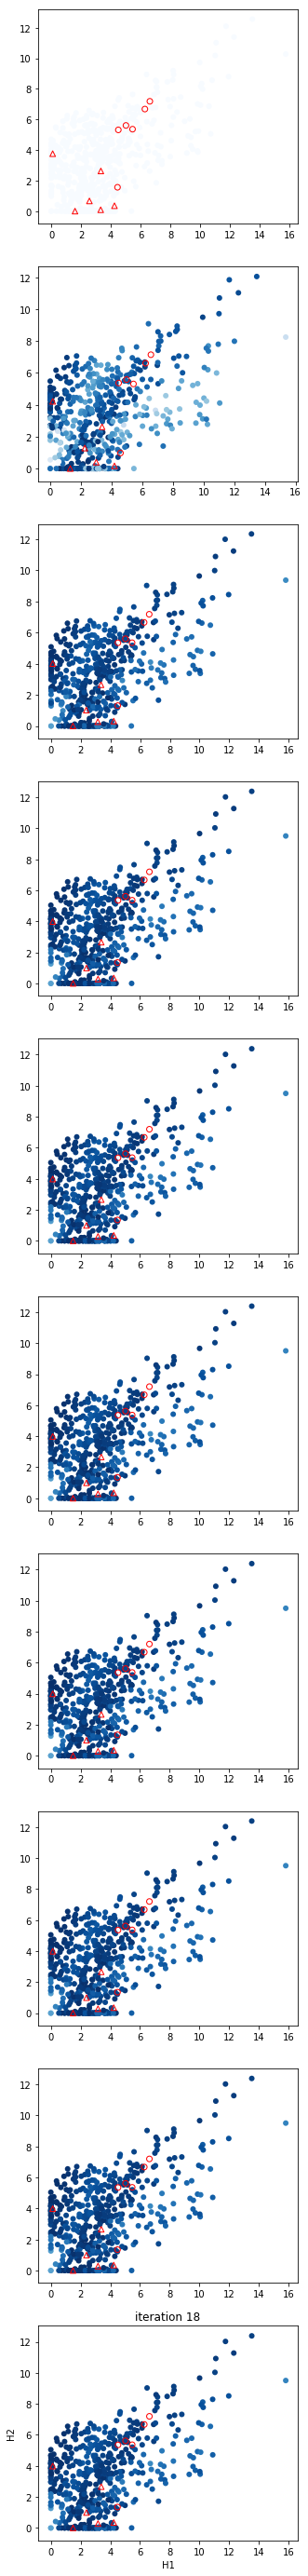

In [147]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

choice = 'max'
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
   
    
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration/2].scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='red', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    plt.title('iteration {}'.format(iteration))


### test homes

In [ ]:
out= {}

for choice in ['max']:
    out[choice] = {}
    for iteration in range(num_iterations):
        print choice, iteration
        out_v[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[iteration][appliance]).loc[test_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

max 0
hvac
fridge
mw
dw
wm
oven
max 1
hvac
fridge
mw
dw
wm
oven
max 2
hvac
fridge
mw
dw
wm
oven
max 3
hvac
fridge
mw
dw
wm
oven
max 4
hvac
fridge
mw
dw
wm
oven
max 5
hvac
fridge
mw
dw
wm
oven
max 6
hvac
fridge
mw
dw
wm
oven
max 7
hvac
fridge
mw
dw
wm
oven
max 8
hvac
fridge
mw
dw
wm
oven
max 9
hvac
fridge
mw
dw
wm
oven
max 10
hvac
fridge
mw
dw


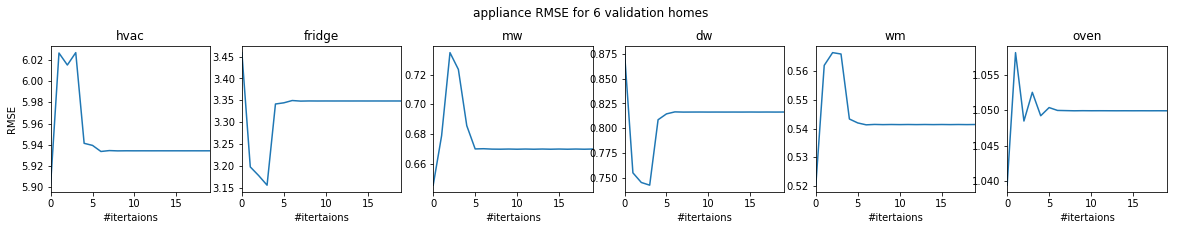

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = pd.DataFrame(out_v['max'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v.T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['same cluster', 'different cluster'], loc='center left')
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-RMSE_test_same_diff.pdf", format='pdf')

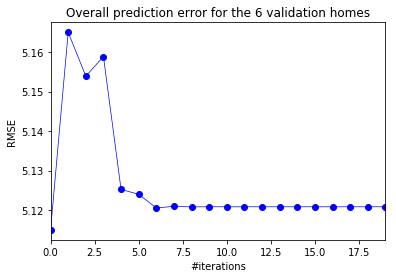

In [149]:
fig, ax = plt.subplots()
error_v = {}
error_v = (mean_out_v.T*pd.Series(contri['Austin'])).sum(axis=1)
error_v.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
# plt.savefig("overall-RMSE_validate.pdf", format='pdf')

### validation homes

In [138]:
out_v = {}

for choice in ['max']:
    out_v[choice] = {}
    for iteration in range(num_iterations):
        print choice, iteration
        out_v[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_validation[iteration][appliance]).loc[validate_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

max 0
hvac
fridge
mw
dw
wm
oven
max 1
hvac
fridge
mw
dw
wm
oven
max 2
hvac
fridge
mw
dw
wm
oven
max 3
hvac
fridge
mw
dw
wm
oven
max 4
hvac
fridge
mw
dw
wm
oven
max 5
hvac
fridge
mw
dw
wm
oven
max 6
hvac
fridge
mw
dw
wm
oven
max 7
hvac
fridge
mw
dw
wm
oven
max 8
hvac
fridge
mw
dw
wm
oven
max 9
hvac
fridge
mw
dw
wm
oven
max 10
hvac
fridge
mw
dw
wm
oven
max 11
hvac
fridge
mw
dw
wm
oven
max 12
hvac
fridge
mw
dw
wm
oven
max 13
hvac
fridge
mw
dw
wm
oven
max 14
hvac
fridge
mw
dw
wm
oven
max 15
hvac
fridge
mw
dw
wm
oven
max 16
hvac
fridge
mw
dw
wm
oven
max 17
hvac
fridge
mw
dw
wm
oven
max 18
hvac
fridge
mw
dw
wm
oven
max 19
hvac
fridge
mw
dw
wm
oven


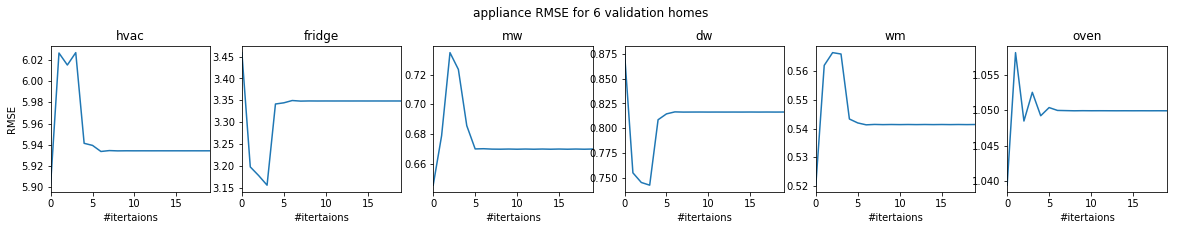

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = pd.DataFrame(out_v['max'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v.T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['same cluster', 'different cluster'], loc='center left')
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-RMSE_test_same_diff.pdf", format='pdf')

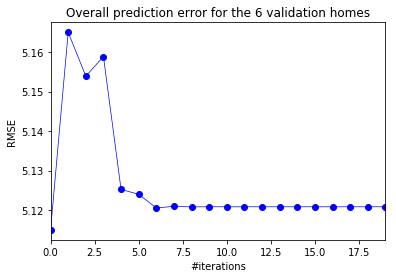

In [149]:
fig, ax = plt.subplots()
error_v = {}
error_v = (mean_out_v.T*pd.Series(contri['Austin'])).sum(axis=1)
error_v.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
# plt.savefig("overall-RMSE_validate.pdf", format='pdf')

In [112]:
out_v = {}
for tv_type in ['same', 'diff']:
    out_v[tv_type] = {}
    for choice in ['max', 'min']:
        out_v[tv_type][choice] = {}
        for iteration in range(num_iterations):
            print tv_type, choice, iteration
            out_v[tv_type][choice][iteration] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                if tv_type == 'same':
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                else: 
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                if appliance=="hvac":
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

same max 0
same max 1
same max 2
same max 3
same max 4
same max 5
same max 6
same max 7
same max 8
same max 9
same max 10
same max 11
same max 12
same max 13
same max 14
same max 15
same max 16
same max 17
same max 18
same max 19
same min 0
same min 1
same min 2
same min 3
same min 4
same min 5
same min 6
same min 7
same min 8
same min 9
same min 10
same min 11
same min 12
same min 13
same min 14
same min 15
same min 16
same min 17
same min 18
same min 19
diff max 0
diff max 1
diff max 2
diff max 3
diff max 4
diff max 5
diff max 6
diff max 7
diff max 8
diff max 9
diff max 10
diff max 11
diff max 12
diff max 13
diff max 14
diff max 15
diff max 16
diff max 17
diff max 18
diff max 19
diff min 0
diff min 1
diff min 2
diff min 3
diff min 4
diff min 5
diff min 6
diff min 7
diff min 8
diff min 9
diff min 10
diff min 11
diff min 12
diff min 13
diff min 14
diff min 15
diff min 16
diff min 17
diff min 18
diff min 19


KeyError: 'min'

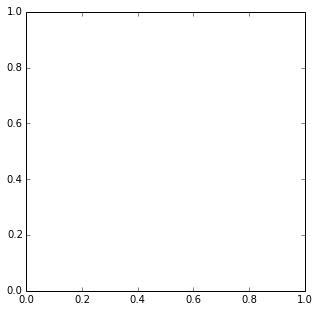

In [117]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
fig, ax = plt.subplots(figsize=(5,5))
choice = "min"
for iteration in [6]:
    X = H[choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
#     x1 = 2
#     x2 = 0
    
    train_sim = weight_matrices[choice][iteration][:].mean(axis=1).mean(axis=1)
    ax.scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    ax.scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    ax.scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    ax.set_title("iteration {}". format(iteration))
    
    plt.savefig("weight_iteration_6_{}.pdf".format(choice), format='pdf')
#     axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

### test homes

In [49]:
out = {}
for choice in ['max', 'min']:
    out[choice] = {}
    for iteration in range(num_iterations):
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            if appliance=="hvac":
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

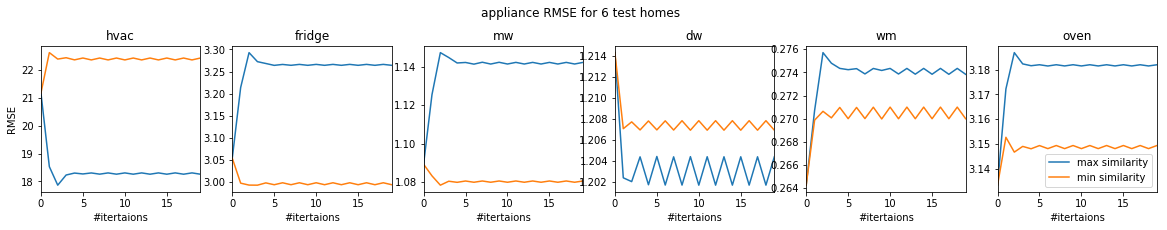

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['min'] = pd.DataFrame(out['min'])
mean_out['max'] = pd.DataFrame(out['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

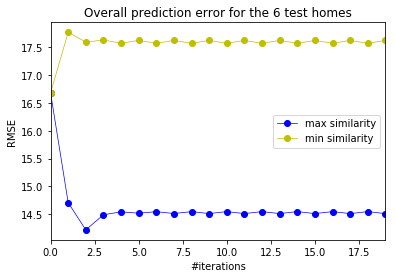

In [102]:
fig, ax = plt.subplots()
error['max'] = (mean_out['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error['min'] = (mean_out['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_test.pdf", format='pdf')

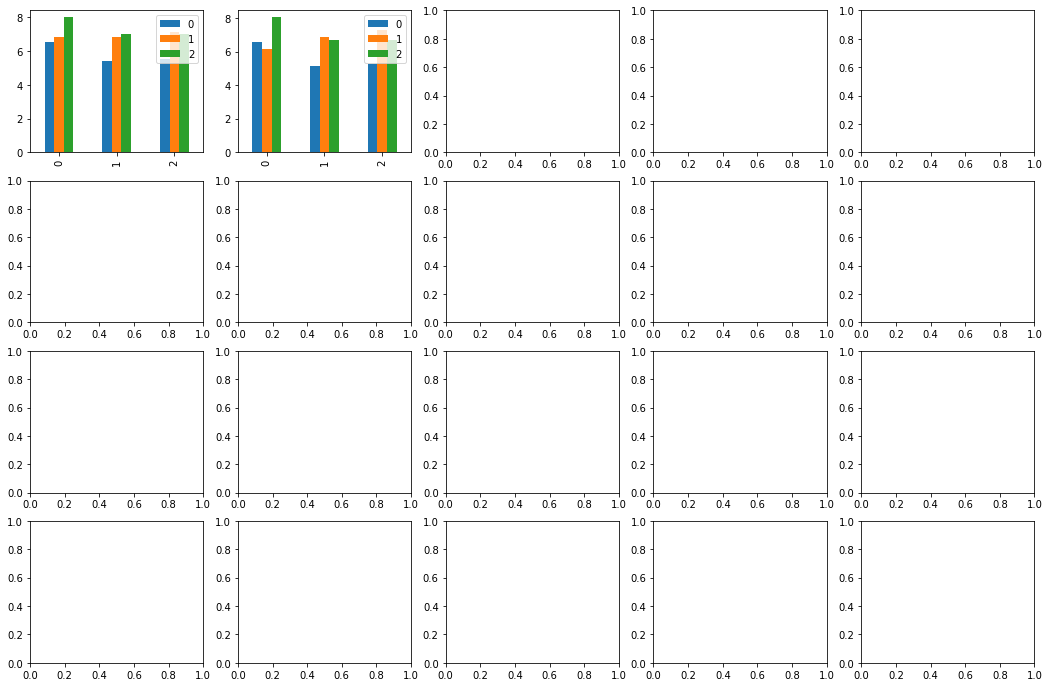

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))


pd.DataFrame(A['max'][2][0]).plot(ax=axes[0][0], kind='bar')
pd.DataFrame(A['min'][2][0]).plot(ax=axes[0][1], kind='bar')


In [26]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.720437494274
1
0.0135169107494
2
0.85064710518
3
0.782826517102
4
0.586187154995
5
0.968014577588
6
0.824718495544
7
0.919507619139
8
0.529737241121
9
0.349787779521


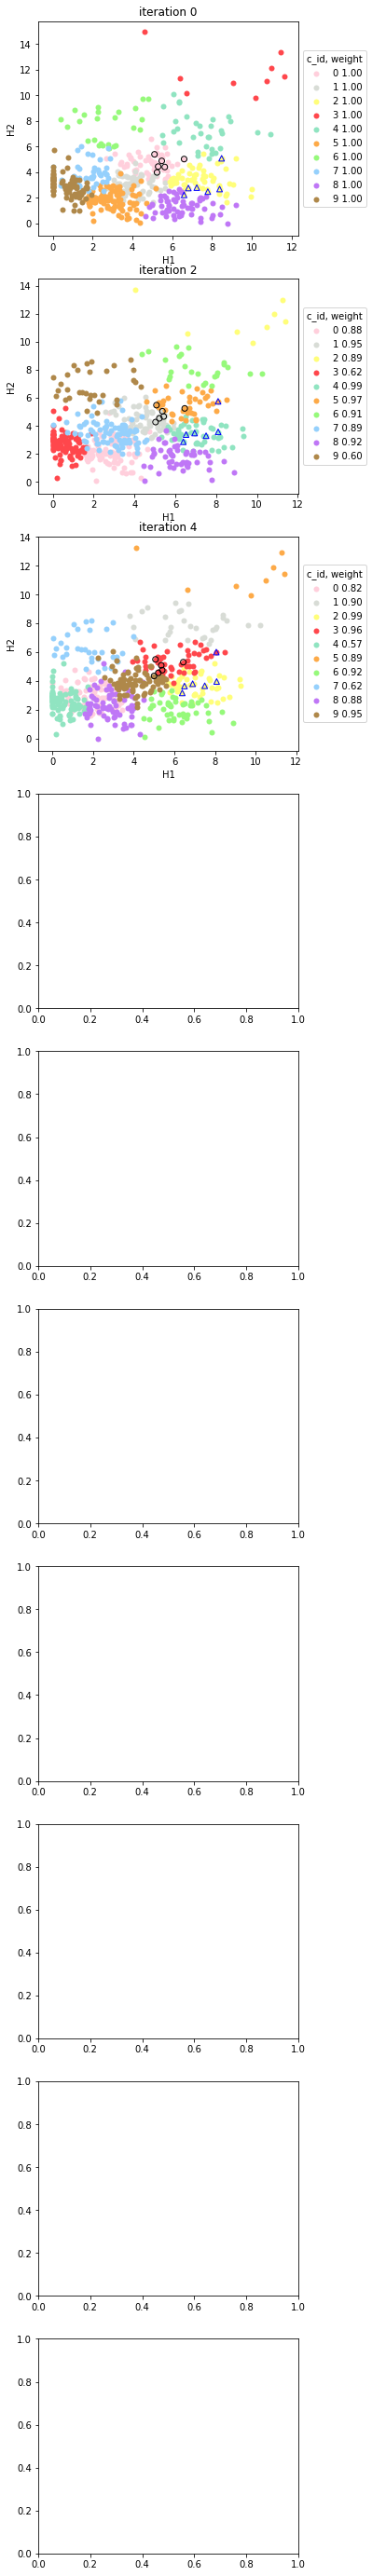

In [127]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")